In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [2]:
%matplotlib notebook

In [96]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_05_11")
velocities = np.array([300,  500, 1000, 2000, 3000, 4000, 5000])
dt = 1 / 565

waveforms = {d: {v: [] for v in velocities} for d in ["DD", "PD"]}
for f in os.listdir(os.path.join(data_path, "waveforms2")):
    waves = pd.read_csv(os.path.join(data_path, "waveforms2", f), skiprows=1).values.T
    for v, w in zip(velocities, waves):
        if not np.isnan(w).any():
            waveforms[f[:2]][v].append(w)

waveforms = {
    d: {v: np.stack(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms.items()
}

avg_waveforms = {
    d: {v: np.mean(ws, axis=0) for v, ws in vels.items()} 
    for d, vels in waveforms.items()
}

rec_xaxis = np.arange(len(avg_waveforms["DD"][300])) * dt

<IPython.core.display.Javascript object>


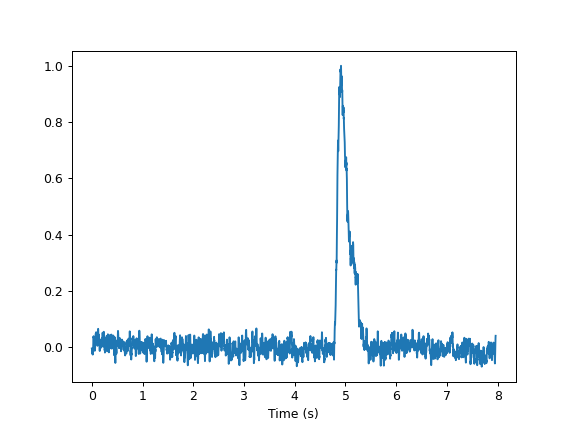

Text(0.5, 0, 'Time (s)')

In [98]:
depth = "DD"
vel = 500
ex = avg_waveforms[depth][vel] / np.max(avg_waveforms[depth][vel])
ex_event = ex[2700:3100]

ex_fig, ex_ax = plt.subplots(1)
ex_ax.plot(rec_xaxis, ex)
ex_ax.set_xlabel("Time (s)")

<IPython.core.display.Javascript object>


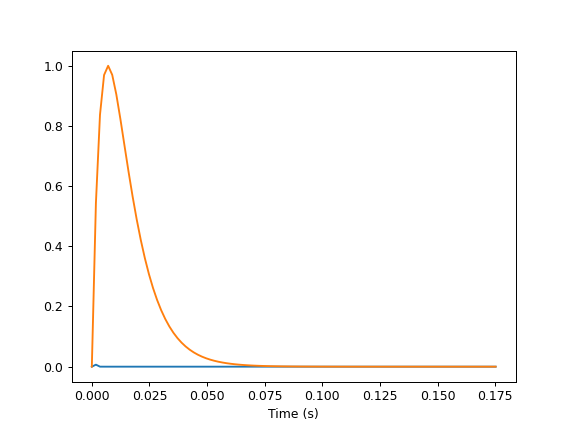

Text(0.5, 0, 'Time (s)')

In [108]:
tau1 = 5 # ms
tau2 = 10
n_pts = 100

dummy = BiexpFitter(1, 10, norm_amp=True)
dummy_fit = dummy.model(
    t=np.arange(n_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]

def biexp(x, m, t1, t2, b):
    return m * (np.exp(-t1 * x) - np.exp(-t2 * x)) + b

bi_fit = biexp(np.arange(n_pts), 1., tau1, tau2, 0)

# fit_xaxis = np.arange(n_pts) / 1000
fit_xaxis = np.arange(n_pts) * dt

biexp_fig, biexp_ax = plt.subplots(1)
biexp_ax.plot(fit_xaxis, bi_fit)
biexp_ax.plot(fit_xaxis, dummy_fit)
biexp_ax.set_xlabel("Time (s)")

In [126]:
# ev = ex
ev = ex_event
scaled_fit = dummy_fit * 0.2
ev_xaxis = np.arange(len(ev)) * dt
dummy_fft = np.fft.rfft(scaled_fit, n=len(ev))
event_fft = np.fft.rfft(ev)
inv = np.fft.irfft(event_fft / dummy_fft)
deconv = np.convolve(inv, scaled_fit)

<IPython.core.display.Javascript object>


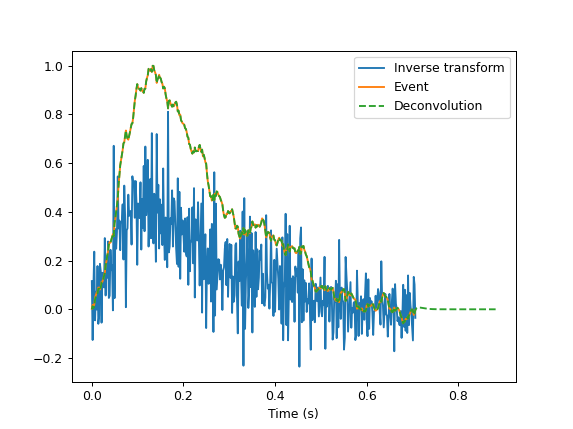

In [127]:
inv_fig, inv_ax = plt.subplots(1)
inv_ax.plot(ev_xaxis, inv, label="Inverse transform")
inv_ax.plot(ev_xaxis, ev, label="Event")
inv_ax.plot(np.arange(len(deconv)) * dt, deconv, label="Deconvolution", linestyle="--")
inv_ax.set_xlabel("Time (s)")
inv_ax.legend()
inv_fig.show()

In [143]:
def bin_sum(x, sz):
    return np.array([
        np.sum(x[i*sz:(i+1)*sz]) for i in range(len(x) // sz)
    ])

# bin_t = 0.01  # s
# sz = int(bin_t / dt)
sz = 10
bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
binned = bin_sum(inv, sz)

<IPython.core.display.Javascript object>


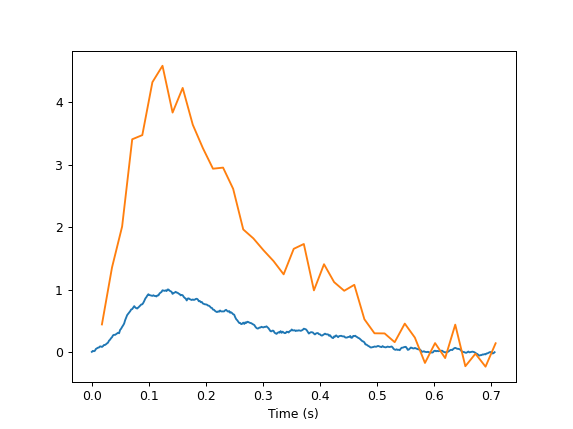

Text(0.5, 0, 'Time (s)')

In [150]:
bin_fig, bin_ax = plt.subplots(1)
bin_ax.plot(ev_xaxis, ev)
bin_ax.plot(bin_edges, binned)
bin_ax.set_xlabel("Time (s)")

In [170]:
def raster(bins, thresh=1., max_q=3):
    def quantize(a):
        return np.clip(np.floor(a / thresh), a_min=0, a_max=max_q)
    return np.array([quantize(b) for b in bins])

<IPython.core.display.Javascript object>


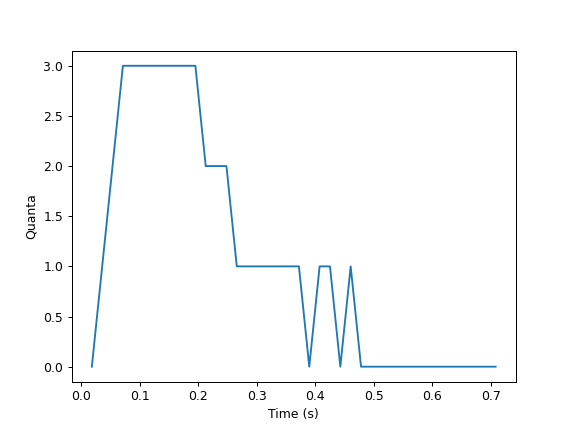

Text(0, 0.5, 'Quanta')

In [172]:
raster_fig, raster_ax = plt.subplots(1)
raster_ax.plot(bin_edges, raster(binned))
raster_ax.set_xlabel("Time (s)")
raster_ax.set_ylabel("Quanta")